In [1]:
print("Kharkovnyk Artem. KI-191")

Kharkovnyk Artem. KI-191


In [2]:
# import libraies
from cv2 import imread               # image reading
import numpy as np                   # linear algebra
from matplotlib.pyplot import imshow # image show
import time                          # time management
import copy 

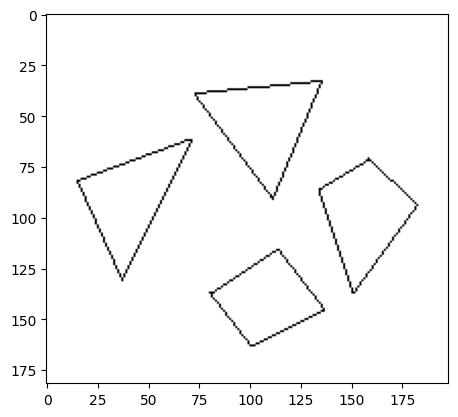

In [3]:
# step 1. Read image
image = imread('test.png')
imshow(image)

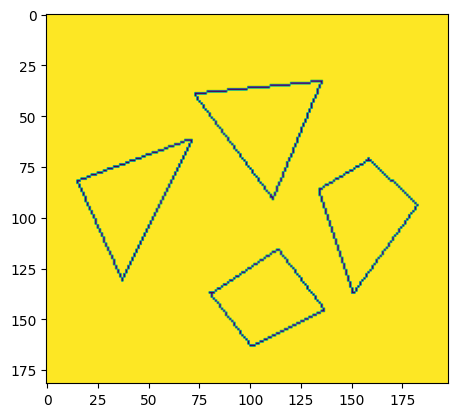

In [4]:
# step 2. Make image grayscale
# notebook shows grayscale image as yellow and blue image
def go_to_grayscale(image):
    # (R + G + B) / 3
    return image.sum(axis=2) / 3

gray_image = go_to_grayscale(image)
imshow(gray_image)

Corner coeficients computing time 0.9971814155578613 sec
Corners selection time 0.08260250091552734 sec


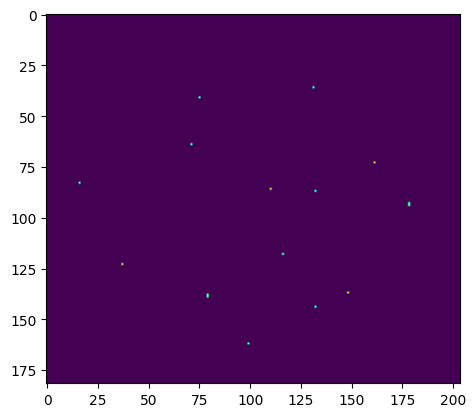

In [5]:
# step 3. create corners map
# 
# https://www.youtube.com/watch?v=Z_HwkG90Yvw
# link above - describing of the algorithm


def corner_detection(image, k = 0.05):
    def harris_corner_detection(kernel, k):
        # Idx -> delta image / delta x
        # Idy -> delta image / delta y
        Idx1 = kernel[:, 1:] - kernel[:, :-1]
        Idy1 = kernel[1:, :] - kernel[:-1, :]
        Idx2 = kernel[:, :-1] - kernel[:, 1:]
        Idy2 = kernel[:-1, :] - kernel[1:, :]
        a = ((Idx1 * Idx1).sum() + (Idx2 * Idx2).sum() ) / 2
        c = ((Idy1 * Idy1).sum() + (Idy2 * Idy2).sum() ) / 2
        b = (Idx1[:-1, :] * Idy1[:, :-1]).sum() + (Idx2[:-1, :] * Idy2[:, :-1]).sum()
        length1 = 0.5 * (a + c + np.sqrt(b**2 + (a - c)**2))
        length2 = 0.5 * (a + c - np.sqrt(b**2 + (a - c)**2))
        R = length1 * length2 - k * (length1 + length2)**2
        return R
    
    def is_max_func(kernel):
        max_value = kernel.max()
        if max_value == 0:
            return 0
        if kernel[3][3] == max_value:
            if max_value > 2e+10:
                return 1
                
        return 0
        
    image = np.append(image, np.zeros([image.shape[0], 3]), axis=1)
    
    newimg = np.zeros(image.shape)
    image = np.append(np.ones([image.shape[0], 3]) * 255, image, axis=1)
    image = np.append(image, np.ones([image.shape[0], 3]) * 255, axis=1)
    image = np.append(image, np.ones([3, image.shape[1]]) * 255, axis=0)
    image = np.append(np.ones([3, image.shape[1]]) * 255, image,  axis=0)
    start = time.time()
    for y in range(0, image.shape[0]-7, 1):
        for x in range(0, image.shape[1]-7, 1):
            kernel = image[y:y+7, x:x+7]
            newimg[y][x] = harris_corner_detection(kernel, k)
    print('Corner coeficients computing time', time.time() - start, 'sec')
    image = newimg
    image = np.append(image, np.zeros([image.shape[0], 3]), axis=1)
    newimg = np.zeros(image.shape)
    image = np.append(np.zeros([image.shape[0], 3]), image, axis=1)
    image = np.append(image, np.zeros([3, image.shape[1]]), axis=0)
    image = np.append(np.zeros([3, image.shape[1]]), image, axis=0)
    start = time.time()
    for y in range(0, image.shape[0]-7, 1):
        for x in range(0, image.shape[1]-7, 1):
            kernel = image[y:y+6, x:x+6]
            newimg[y][x] = is_max_func(kernel)
    print('Corners selection time', time.time() - start, 'sec')  
    return newimg 
            
corner_map = corner_detection(gray_image, 0.2)
imshow(corner_map)

Creating time: 0.9182889461517334 sec


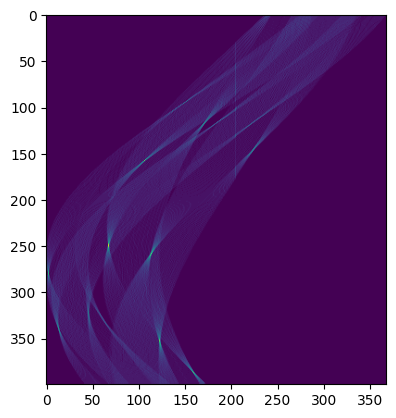

In [6]:
# step 4 detecting lines
# step 4.1 creating matrix of theta and p values
# detectinig lines

# https://www.youtube.com/watch?v=XRBc_xkZREg
# link above - describing of the algorithm

def create_theta_matrix(gray_image, thetas_number=1000):
    start = time.time()
    gray_image = np.abs(gray_image / 255 - 1)
    def create_corners_matrix(gray_image, number_corners):
        corners = np.zeros([number_corners, 2])
        index = 0
        for y in range(gray_image.shape[0]):
            for x in range(gray_image.shape[1]):
                if gray_image[y][x] == 1:
                    corners[index][0] = x
                    corners[index][1] = y
                    index = index + 1
        return corners
    
    thetas = np.array((range(thetas_number))) / (thetas_number - 1) * np.pi
    number_corners =  int(gray_image.sum())
    corners = create_corners_matrix(gray_image, number_corners)
    plists = list()
    for rowid, theta in enumerate(thetas):
        plist = list()
        for colid, corner in enumerate(corners):
            x, y = corner
            p = int(y * np.cos(theta) - x * np.sin(theta))
            plist.append(p)
        plists.append(plist)
    p = np.array(plists)
    delta = p.min()
    p = p - delta
    M = np.zeros([thetas_number, p.max()+1])
    for theta_id in range(thetas_number):
        for i in range(p.shape[1]):
            M[theta_id][p[theta_id][i]] = M[theta_id][p[theta_id][i]] + 1
    print("Creating time:", time.time() - start, 'sec')
    return M, delta
NUMBER_THETA = 400
M, delta = create_theta_matrix(gray_image, NUMBER_THETA)
imshow(M)

59

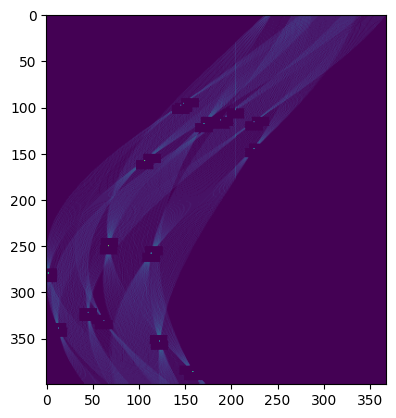

In [7]:
# step 4.2 selecting bigest values of corner map

# algorithm based of seraching values biger than "limit".
# then in range of "half_kernel_size" searching the biges value
# and other area equel to zero

def finding_intersections(M, limit, half_kernel_size):
    h = half_kernel_size
    dots = []
    m = None
    for y in range(M.shape[0]):
        for x in range(M.shape[1]):
            if M[y][x] >= limit:
                if y+h >= image.shape[0]:
                    if x+h >= image.shape[0]:
                         m = M[y:, x-h:].max()
                    elif x-h < 0:
                        m = M[y:, :x+h].max()
                    else:
                        m = M[y:, x-h:x+h].max()
                else:
                    if x+h >= image.shape[0]:
                         m = M[y:y+h, x-h:].max()
                    elif x-h < 0:
                        m = M[y:y+h, :x+h].max()
                    else:
                        m = M[y:y+h, x-h:x+h].max()
               
                    
                
                for i in range(h):
                    for j in range(h):
                        try:
                            if M[y+i][x+j] == m:
                                dots.append([x+j, y+j, M[y+i][x+j]])
                            else:
                                M[y+i][x+j] = 0
                            if M[y+i][x-j] == m:
                                dots.append([x-j, y+j, M[y+i][x-j]])
                            else:
                                M[y+i][x-j] = 0
                        except:
                            pass
    imshow(M)
    return dots

dots = finding_intersections(copy.copy(M), 20, 10)
len(dots)

In [8]:
# step 4.3 
# each line can be described as function y = kx + b
# now we transform dots [theta, p] -> [k, b]

def get_k_and_b_coeficients(dots, number_thetas, delta):
    res = []
    for dot in dots:
#         theta_id, p, v = dot
        p, theta_id, v = dot
        theta = np.pi / (number_thetas - 1) * theta_id
        p = p + delta
        k = np.tan(theta)
        b = p / np.cos(theta)
        res.append([k, b])
    return res
        
kb_list = get_k_and_b_coeficients(dots, NUMBER_THETA, delta)

In [9]:
# step 4.4
# create image to verify coeficients of lines

def draw_lines(image, kb_list):
    for kb in kb_list:
        k, b = kb
        for x in range(image.shape[1]):
            y = int(k * x + b)
            if y >= 0 and y < image.shape[0]:
                for i, color in zip(range(3), [255, 0, 0]):
                    image[y][x][i] = color
    return image
image_with_lines = draw_lines(copy.copy(image), kb_list)

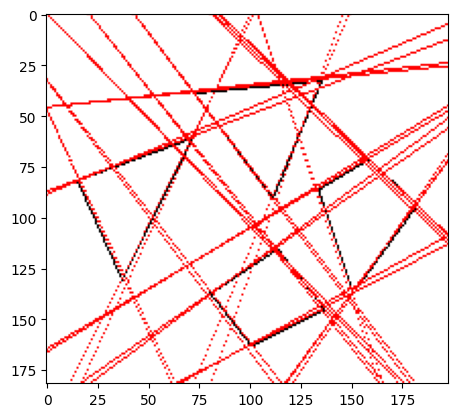

In [10]:
# as we see there are a lot of lines and each figure line has at least one coresponding fuction

imshow(image_with_lines)

In [11]:
# step 5 join corners to figures

# step 5.1 creating Corner class
# this class contain information of bounded corners and its coordiantes in the image
class Corner:
    def __init__(self, x, y, line_funcs, eps):
        self.x = x
        self.y = y
        self.funcs = []
        for func in line_funcs:
            y_ = func(x)
            if np.abs(y_ - y) < eps:
                self.funcs.append(func)
        self.bound_corners = []
                
    def is_bound(self, corner):
        for f1 in self.funcs:
            for f2 in corner.funcs:
                if f1.id == f2.id:
                    return True
        return False
    
    def add_bound(self, corner):
        self.bound_corners.append(corner)
        
    def __repr__(self):
        return str([self.x, self.y])
        
    def search_corner(self, corner, ignore_list=[], first=False, second=False):
        if self in ignore_list: 
            return None
        if first: 
            for c in self.bound_corners:
                res = c.search_corner(corner,  second=True)
                if res is not None:
                    if len(res) == len(set(res)):
                        return [self] + res
            return None
        if second:
            for c in self.bound_corners:
                if c != corner:
                    res = c.search_corner(corner, ignore_list=list())
                    if res is not None:
                        return [self] + res
            return None
        
        if corner == self:
            return []
        cp_ignore_list = copy.copy(ignore_list)
        cp_ignore_list.append(self)
        for c in self.bound_corners:
            res = c.search_corner(corner, ignore_list=cp_ignore_list)
            if res is not None:
                return [self] + res
        return None

In [12]:
# step 5.2 storing k and b coeficients if the linear fuction for,
def create_line_functions(kb_list):
    def create_inner(i, k, b):
        def inner(x):
            return k * x + b
        inner.id = i
        return inner
    functions = []
    for i, kb in enumerate(kb_list):
        k, b = kb
        
        functions.append(create_inner(i, k, b))
    return functions

line_functions = create_line_functions(kb_list)

In [13]:
# step 5.3 create corners objects
def get_corners(corner_map, line_funcs, eps):
    corners = []
    for y in range(0, corner_map.shape[0]):
        for x in range(0, corner_map.shape[1]): 
            if corner_map[y][x] != 0:
                corners.append(Corner(x, y, line_funcs, eps))
    return corners
corners = get_corners(corner_map, line_functions, 7)

In [14]:
# step 5.4 searching the figures
# each figure it is sequence of corners
def find_figures(corenrs):
    def figures_has_figure(figures, figure):
        if len(figures) == 0 :
            return False
        for fig in figures:
            for el in figure:
                if el not in fig:
                    return False
        return True
    for corner1 in corners:
        for corner2 in corners:
            if corner1 != corner2:
                if corner1.is_bound(corner2):
                    corner1.add_bound(corner2)
    figures = []
    for corner in corenrs:
        figure = corner.search_corner(corner, first=True)
        if figure:
            if figures_has_figure(figures, figure) is False:
                figures.append(figure)
        
    return figures
        
figures = find_figures(corners)


In [15]:
# step 5.5 check figures
figures

[[[131, 36], [75, 41], [110, 86]],
 [[71, 64], [16, 83], [37, 128]],
 [[116, 118], [79, 138], [99, 162], [132, 144]],
 [[132, 87], [148, 137], [178, 93], [161, 73]]]

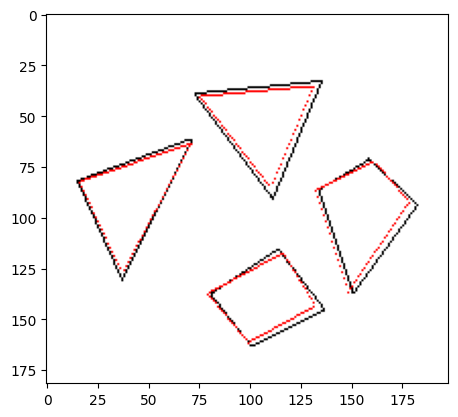

In [16]:
# step 5.6 draw figures on the image

# as we see figures are now exactly same as given figures but they similar enough
def draw_figure(image, figure):
    def draw_line(image, x1, y1, x2, y2):
        dx = x2 - x1
        dy = y2 - y1
        k = dy/dx
        b = y1 - k * x1
        step = int((x2 - x1) / np.abs(x2 - x1))
        for x in range(x1, x2, step):
            y = int(k * x + b)
            image[y][x] = image[y][x] * 0
            image[y][x] = image[y][x] + np.array([255, 0, 0])
        return image
    for i in range(len(figure) - 1):
        corner1 = figure[i]
        corner2 = figure[i + 1]
        image = draw_line(image, corner1.x, corner1.y, corner2.x, corner2.y)
    corner1 = figure[0]
    corner2 = figure[i + 1]
    image = draw_line(image, corner1.x, corner1.y, corner2.x, corner2.y)
    return image

img_with_fig = copy.copy(image)
for figure in figures:
    img_with_fig = draw_figure(img_with_fig, figure)
imshow(img_with_fig)

In [17]:
# step 6 searching triangles

number_of_triangles = 0
for figure in figures:
    if len(figure) == 3:
        print('figure is triangle:', figure)
        number_of_triangles = number_of_triangles + 1
print(f'found {number_of_triangles} triangles')
    

figure is triangle: [[131, 36], [75, 41], [110, 86]]
figure is triangle: [[71, 64], [16, 83], [37, 128]]
found 2 triangles


In [18]:
# step 7 searching rectangules
def rectangule_err(figure):
    c1, c2, c3, c4 = figure
    v1 = [c2.x - c1.x, c2.y - c1.y]
    v2 = [c4.x - c1.x, c4.y - c1.y]
    v3 = [c2.x - c3.x, c2.y - c3.y]
    v4 = [c4.x - c3.x, c4.y - c3.y]
    return v1[0] * v2[0] + v1[1] * v2[1] + v3[0] * v4[0] + v3[1] * v4[1]
    

number_of_rectangules = 0
for figure in figures:
    if len(figure) == 4:
        err = rectangule_err(figure)
        if np.abs(err) < 400:
            print('figure is rectangule:', figure)
            number_of_rectangules = number_of_rectangules + 1
        else:
            print('figure has 4 corners but it is not rectangule:', figure)
print(f'found {number_of_rectangules} rectangules')
        

figure is rectangule: [[116, 118], [79, 138], [99, 162], [132, 144]]
figure has 4 corners but it is not rectangule: [[132, 87], [148, 137], [178, 93], [161, 73]]
found 1 rectangules
